# 1. Kết nối với Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 2. Import các thư viện cần thiết và xác thực

In [2]:
from google.colab import auth
from googleapiclient.discovery import build
from collections import defaultdict
import re
import csv

# Xác thực và xây dựng service client
auth.authenticate_user()
drive_service = build('drive', 'v3')


# 3. Lấy thông tin các tệp từ thư mục

In [3]:
folder_id = '1Uj0V9URNHpzSHeXHSB89AoGCjGki8Yra'

# Lấy danh sách các tệp trong thư mục
results = drive_service.files().list(
    q=f"'{folder_id}' in parents",
    fields="files(id, name)"
).execute()

files = results.get('files', [])

# Đếm số lượng tệp
file_count = len(files)

# Hiển thị số lượng tệp và tên tệp
print(f'Số lượng tệp trong thư mục: {file_count}')
for file in files:
    print(f"{file['name']} (ID: {file['id']})")


Số lượng tệp trong thư mục: 19
DuplicateDetectionResults_1.csv (ID: 16jBHjfPIKIWwVWSF0l0ZGAtEAvWvFX2-)
CS114.P11.Clustering.ipynb (ID: 1B-lBqWHEgg2xkcpu-lSkFbrQdU9osULr)
runs (ID: 1yIx2onssy-7RRPpQkvWzqMafZwMAqIJH)
Log_ass3 (ID: 1SbW4_37RTlyD6DWoYON5D7Yr_eZcGf0L)
CS114.P11.Tool.DatasetViz.ipynb (ID: 1e-OX0-jzEBf9YxUkEQWT9jcvfsjWl8uJ)
features.npy (ID: 1eoilZQu4ljV8wlvcpp8Tnz2MKzFACqOb)
labels.npy (ID: 1I-RAVgLvQTnVYbfBEYPj3P3DySEwpZ9z)
Bản sao của Public (ID: 1pOXqrxGStQBcuiZxlAWFiIt_wfXg1A42)
Public (ID: 1i2IP_cH5zdasYuBdvveKYVvkO17DJoDj)
Toyota (ID: 1E9X8-Pze6ortHNdtYQZXpxLcaPOXmwHO)
Suzuki (ID: 1GtN432Don56OgCxHUCZmzKBt66L9fE-I)
Others (ID: 1qXcnNpj5tVbJijBDoJ4xVmIOY0rO8tgy)
Mitsubishi (ID: 1Cp1Qscg5WVcbnqfed_2yCLM4wlRlmt5Q)
Mazda (ID: 1ig3DyO-1BTprx2Su1uSddNwAhhtWXhx_)
KIA (ID: 11EtthMFFPbA2XCRuO5J-DtMeJTb9a6BF)
Hyundai (ID: 1ChI_onzuYHv7jsjzhx8qG9gPW2joZ7yU)
Honda (ID: 1gBatGmadQ56axOqA8tAd-eb3-OiYum0r)
CS114.P11.Tool.CreateSplit.Car.ipynb (ID: 14AwNYmDRqDcE4p54b0NfRI6e59fYD3U4)
C

# 4. Thống kê số lượng ảnh trong các thư mục

## 4.1: Chỉ lấy các thư mục chưa các ảnh để làm việc(9 thư mục)

In [4]:
folder_ids = {
    "VinFast": '1saD5w8q52UhD4YTeTgpXYX5UF_ONzmrp',
    "Toyota": '1E9X8-Pze6ortHNdtYQZXpxLcaPOXmwHO',
    "Suzuki": '1GtN432Don56OgCxHUCZmzKBt66L9fE-I',
    "Others": '1qXcnNpj5tVbJijBDoJ4xVmIOY0rO8tgy',
    "Mitsubishi": '1Cp1Qscg5WVcbnqfed_2yCLM4wlRlmt5Q',
    "Mazda": '1ig3DyO-1BTprx2Su1uSddNwAhhtWXhx_',
    "KIA": '11EtthMFFPbA2XCRuO5J-DtMeJTb9a6BF',
    "Hyundai": '1ChI_onzuYHv7jsjzhx8qG9gPW2joZ7yU',
    "Honda": '1gBatGmadQ56axOqA8tAd-eb3-OiYum0r'
}


## 4.2: Hàm đếm tổng số lượng ảnh trong mỗi thư mục

In [5]:

def count_image_files_in_folder(folder_id):
    image_count = 0
    page_token = None
    accepted_extensions = ['.jpg', '.jpeg', '.png']

    while True:
        results = drive_service.files().list(
            q=f"'{folder_id}' in parents",
            fields="files(id, name), nextPageToken",
            pageToken=page_token
        ).execute()

        files = results.get('files', [])
        for file in files:
            file_name = file['name'].lower()
            if any(file_name.endswith(ext) for ext in accepted_extensions):
                image_count += 1

        page_token = results.get('nextPageToken')
        if not page_token:
            break

    return image_count

### 4.3:Bắt đầu đếm số lượng tệp ảnh (.jpg, .jpeg, .png) trong từng thư mục(tổng có 34928 ảnh)

In [6]:
for folder_name, folder_id in folder_ids.items():
    image_count = count_image_files_in_folder(folder_id)
    print(f'{folder_name}: {image_count} image files')

VinFast: 0 image files
Toyota: 6192 image files
Suzuki: 6940 image files
Others: 4593 image files
Mitsubishi: 3180 image files
Mazda: 3433 image files
KIA: 3517 image files
Hyundai: 3792 image files
Honda: 3281 image files


# 5. Đếm số lượng ảnh mà từng MSSV đóng góp và hiển thị kết quả.

### 5.1: Hàm trích xuất MSSV từ tên file

In [7]:
import re

# Hàm để trích xuất MSSV từ tên file
def extract_mssv(filename):
    mssv_matches = re.findall(r'\d{8}', filename)
    return mssv_matches


### 5.2: Hàm liệt kê tất cả các tệp trong thư mục


In [8]:
# Hàm liệt kê các tệp trong thư mục và thư mục con
def list_files_in_folder(folder_id):
    files = []
    page_token = None

    while True:
        results = drive_service.files().list(
            q=f"'{folder_id}' in parents",
            fields="files(id, name, mimeType), nextPageToken",
            pageToken=page_token
        ).execute()

        items = results.get('files', [])
        for item in items:
            if item['mimeType'] == 'application/vnd.google-apps.folder':
                files.extend(list_files_in_folder(item['id']))
            else:
                files.append(item['name'])

        page_token = results.get('nextPageToken', None)
        if not page_token:
            break

    return files


### 5.4: Hàm đếm số lượng ảnh từ các MSSV đóng góp

In [9]:
from collections import defaultdict

# Hàm đếm số lượng ảnh mà mỗi sinh viên đóng góp
def count_contributions(files):
    mssv_contributions = defaultdict(int)

    for file in files:
        mssvs = extract_mssv(file)
        if mssvs:
            for mssv in mssvs:
                mssv_contributions[mssv] += 1

    return mssv_contributions


### 5.5: Liệt kê và đếm tất cả các tệp trong thư mục

In [10]:
# Lấy danh sách tất cả các tệp trong thư mục từ các folder_ids
all_files = []
for folder_name, folder_id in folder_ids.items():
    all_files.extend(list_files_in_folder(folder_id))


In [11]:
# Liệt kê tất cả MSSV và đếm số lượng sinh viên
mssvs = list(count_contributions(all_files).keys())
print(f"Số lượng sinh viên đã đóng góp ảnh: {len(mssvs)}")

# Hiển thị danh sách MSSV
print("\nDanh sách các sinh viên (MSSV) đã đóng góp:")
for mssv in sorted(mssvs):
    print(f"- {mssv}")


Số lượng sinh viên đã đóng góp ảnh: 54

Danh sách các sinh viên (MSSV) đã đóng góp:
- 20520918
- 21520930
- 21520938
- 21522373
- 21522377
- 21522499
- 21522500
- 21522771
- 21522924
- 22520195
- 22520211
- 22520213
- 22520223
- 22520318
- 22520348
- 22520394
- 22520395
- 22520459
- 22520477
- 22520490
- 22520507
- 22520521
- 22520530
- 22520550
- 22520581
- 22520634
- 22520683
- 22520779
- 22520811
- 22520837
- 22520862
- 22520884
- 22520914
- 22520915
- 22520967
- 22520970
- 22521027
- 22521060
- 22521070
- 22521213
- 22521259
- 22521342
- 22521425
- 22521463
- 22521465
- 22521492
- 22521559
- 22521560
- 22521586
- 22521587
- 22521599
- 22521614
- 22521676
- 22521692


In [12]:
# Đếm số lượng ảnh mà mỗi sinh viên đã đóng góp
contributions = count_contributions(all_files)

# Hiển thị số lượng ảnh đóng góp của từng sinh viên
print("\nSố lượng ảnh mà từng sinh viên đóng góp:")
for mssv, count in contributions.items():
    print(f"{mssv}, All, {count}")



Số lượng ảnh mà từng sinh viên đóng góp:
21522500, All, 1015
21522771, All, 1015
21520930, All, 599
21522924, All, 1198
22521586, All, 1364
22521559, All, 1364
22521259, All, 329
22521213, All, 329
22521463, All, 329
22521070, All, 2183
22520211, All, 2183
22520394, All, 3202
22520395, All, 3202
22521492, All, 624
22521599, All, 624
22521342, All, 1764
22520970, All, 1764
22520779, All, 2628
22521587, All, 2628
22521560, All, 436
22521614, All, 436
21520938, All, 1046
22520634, All, 1046
22520914, All, 664
22520915, All, 666
22520477, All, 466
22520490, All, 466
22521027, All, 10774
22520195, All, 10774
22521060, All, 10774
21522373, All, 650
21522499, All, 651
22521692, All, 1132
22521676, All, 1132
22520550, All, 164
22520967, All, 164
22520581, All, 100
22520348, All, 421
22520530, All, 421
22520837, All, 421
22520223, All, 209
22520213, All, 209
22520459, All, 3700
22520507, All, 3700
22520862, All, 3700
22520521, All, 268
22520884, All, 268
22521465, All, 219
22520811, All, 219
2

### 5.6: Lưu kết quả

In [13]:
with open('CarDataset-1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Ghi tiêu đề vào file CSV
    writer.writerow(['MSSV', 'All', 'Count'])

    # Ghi kết quả đếm đóng góp vào file
    for mssv, count in contributions.items():
        writer.writerow([mssv, "All", count])

print("Kết quả đã được lưu vào file 'CarDataset-1.csv'.")

Kết quả đã được lưu vào file 'CarDataset-1.csv'.


In [14]:
from google.colab import files
files.download('CarDataset-1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6. Đếm số ảnh mà mỗi MSSV đã đóng góp theo Brand

### 6.1: Trích xuất MSSV và Hãng Xe từ tên file

In [15]:
def extract_mssv_and_brand(filename):
    # Tìm kiếm MSSV (8 chữ số liên tiếp)
    mssv_matches = re.findall(r'\d{8}', filename)
    # Tìm kiếm hãng xe (VinFast, Toyota, Suzuki, v.v.)
    brand_matches = re.findall(r'(VinFast|Toyota|Suzuki|Others|Mitsubishi|Mazda|KIA|Hyundai|Honda)', filename, re.IGNORECASE)
    return mssv_matches, brand_matches


### 6.2: Đếm sự đóng góp của từng MSSV theo hãng xe

In [16]:
# Hàm thống kê số lượng ảnh đóng góp của mỗi sinh viên theo hãng xe
def count_contributions_by_brand(files):
    mssv_contributions_by_brand = defaultdict(lambda: defaultdict(int))

    # Duyệt qua từng tệp trong danh sách files
    for file in files:
        mssvs, brands = extract_mssv_and_brand(file)
        if mssvs and brands:
            for mssv in mssvs:
                for brand in brands:
                    mssv_contributions_by_brand[mssv][brand] += 1

    return mssv_contributions_by_brand


### 6.3: Hiển thị kết quả

In [17]:
contributions_by_brand = count_contributions_by_brand(all_files)

# Hiển thị kết quả
for mssv, brands in contributions_by_brand.items():
    for brand, count in brands.items():
        print(f"{mssv}, {brand}, {count}")


21522500, Toyota, 168
21522500, Suzuki, 167
21522500, Others, 200
21522500, Mitsubishi, 48
21522500, Mazda, 36
21522500, KIA, 35
21522500, Hyundai, 200
21522500, Honda, 161
21522771, Toyota, 168
21522771, Suzuki, 167
21522771, Others, 200
21522771, Mitsubishi, 48
21522771, Mazda, 36
21522771, KIA, 35
21522771, Hyundai, 200
21522771, Honda, 161
21520930, Toyota, 100
21520930, Suzuki, 99
21520930, Mitsubishi, 100
21520930, Mazda, 100
21520930, KIA, 100
21522924, Toyota, 200
21522924, Suzuki, 198
21522924, Mitsubishi, 200
21522924, Mazda, 200
21522924, KIA, 200
22521586, Toyota, 238
22521586, Suzuki, 101
22521586, Others, 249
22521586, Mitsubishi, 154
22521586, Mazda, 287
22521586, KIA, 133
22521586, Hyundai, 93
22521586, Honda, 109
22521559, Toyota, 238
22521559, Suzuki, 101
22521559, Others, 249
22521559, Mitsubishi, 154
22521559, Mazda, 287
22521559, KIA, 133
22521559, Hyundai, 93
22521559, Honda, 109
22521259, Toyota, 15
22521259, Suzuki, 15
22521259, Others, 118
22521259, Mitsubishi,

### 6.4: Lưu kết quả

In [18]:
output_file_path = '/content/CarDataset-2.csv'

with open(output_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['MSSV', 'Brand', 'Count'])

    for mssv, brands in contributions_by_brand.items():
        for brand, count in brands.items():
            writer.writerow([mssv, brand, count])

print(f"Dữ liệu đã được lưu vào file {output_file_path}")


Dữ liệu đã được lưu vào file /content/CarDataset-2.csv


In [19]:
# Tải file về máy tính của bạn
from google.colab import files
files.download(output_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
!pip install gdown

import os

# Dictionary chứa các thư mục và ID
folder_ids = {
    "VinFast": '1saD5w8q52UhD4YTeTgpXYX5UF_ONzmrp',
    "Toyota": '1E9X8-Pze6ortHNdtYQZXpxLcaPOXmwHO',
    "Suzuki": '1GtN432Don56OgCxHUCZmzKBt66L9fE-I',
    "Others": '1qXcnNpj5tVbJijBDoJ4xVmIOY0rO8tgy',
    "Mitsubishi": '1Cp1Qscg5WVcbnqfed_2yCLM4wlRlmt5Q',
    "Mazda": '1ig3DyO-1BTprx2Su1uSddNwAhhtWXhx_',
    "KIA": '11EtthMFFPbA2XCRuO5J-DtMeJTb9a6BF',
    "Hyundai": '1ChI_onzuYHv7jsjzhx8qG9gPW2joZ7yU',
    "Honda": '1gBatGmadQ56axOqA8tAd-eb3-OiYum0r'
}

# Tạo thư mục lưu dữ liệu
os.makedirs('/content/Folders', exist_ok=True)

# Tải từng thư mục
for name, folder_id in folder_ids.items():
    print(f"Downloading folder: {name}")
    os.makedirs(f'/content/Folders/{name}', exist_ok=True)
    !gdown --folder https://drive.google.com/drive/folders/{folder_id} -O /content/Folders/{name}


Retrieving folder contents
Error:

	Cannot retrieve the folder information from the link. You may need to
	change the permission to 'Anyone with the link', or have had many
	accesses. Check FAQ in https://github.com/wkentaro/gdown?tab=readme-
	ov-file#faq.

To report issues, please visit https://github.com/wkentaro/gdown/issues.
Retrieving folder contents
Processing file 1Sf1XNkkOakH_DZMpGUsLhJ8iXspGv0-C 20520918.Toyota.1.jpg
Processing file 1qoRLuzD0uFyQYPikVSHoQF_Mn0S01Ej9 20520918.Toyota.2.jpg
Processing file 1lMgK2YTm-odx561wAkJlGvCafeuN-Lti 20520918.Toyota.3.jpg
Processing file 1Vb0TrrzOftt1aDNNSHilk9l7Kw75IuSA 20520918.Toyota.4.jpg
Processing file 1l9gyA8NlpoBUTLNiux1V78eiaeKxRx6G 20520918.Toyota.5.jpg
Processing file 1Q-x2vlXdz7T83wOOdvO7R-kmpdXpxiRE 20520918.Toyota.6.jpg
Processing file 1bTgbs_f5C6TGjYBakT36Sj1x6DZBSND7 20520918.Toyota.7.jpg
Processing file 1kcu3f0_J5F0rbeS1OSfVroihoZ2VCvX_ 20520918.Toyota.8.jpg
Processing file 1Qpk6LFjmFpwNZazgPyWHVYuBoFMe9jcf 20520918.Toyota.

In [21]:
import os

# Liệt kê tất cả thư mục đã tải
base_path = '/content/Folders'
for folder in os.listdir(base_path):
    print(f"Folder: {folder}")
    print("Files:", os.listdir(os.path.join(base_path, folder)))


Folder: Mazda
Files: []
Folder: VinFast
Files: []
Folder: Mitsubishi
Files: []
Folder: Suzuki
Files: []
Folder: Toyota
Files: []
Folder: Hyundai
Files: []
Folder: KIA
Files: []
Folder: Others
Files: []
Folder: Honda
Files: []


In [22]:
!pip install opencv-python-headless tensorflow numpy


**Biểu đồ biểu diễn số lượng ảnh mà mỗi sinh viên đã đóng góp**

In [29]:
from google.colab import files

# Tải file từ máy tính lên
uploaded = files.upload()


Saving CarDataset-1.csv to CarDataset-1 (1).csv


In [30]:
# Đọc file CSV đã tải lên
import pandas as pd

# Đọc file CSV từ Google Colab
file_path = '/content/CarDataset-1 (1).csv'
car_data = pd.read_csv(file_path)

# Kiểm tra dữ liệu
car_data.head()

,MSSV,Count
0,22520348,470
1,22520530,470
2,22520837,470
3,22520683,264
4,22520811,264


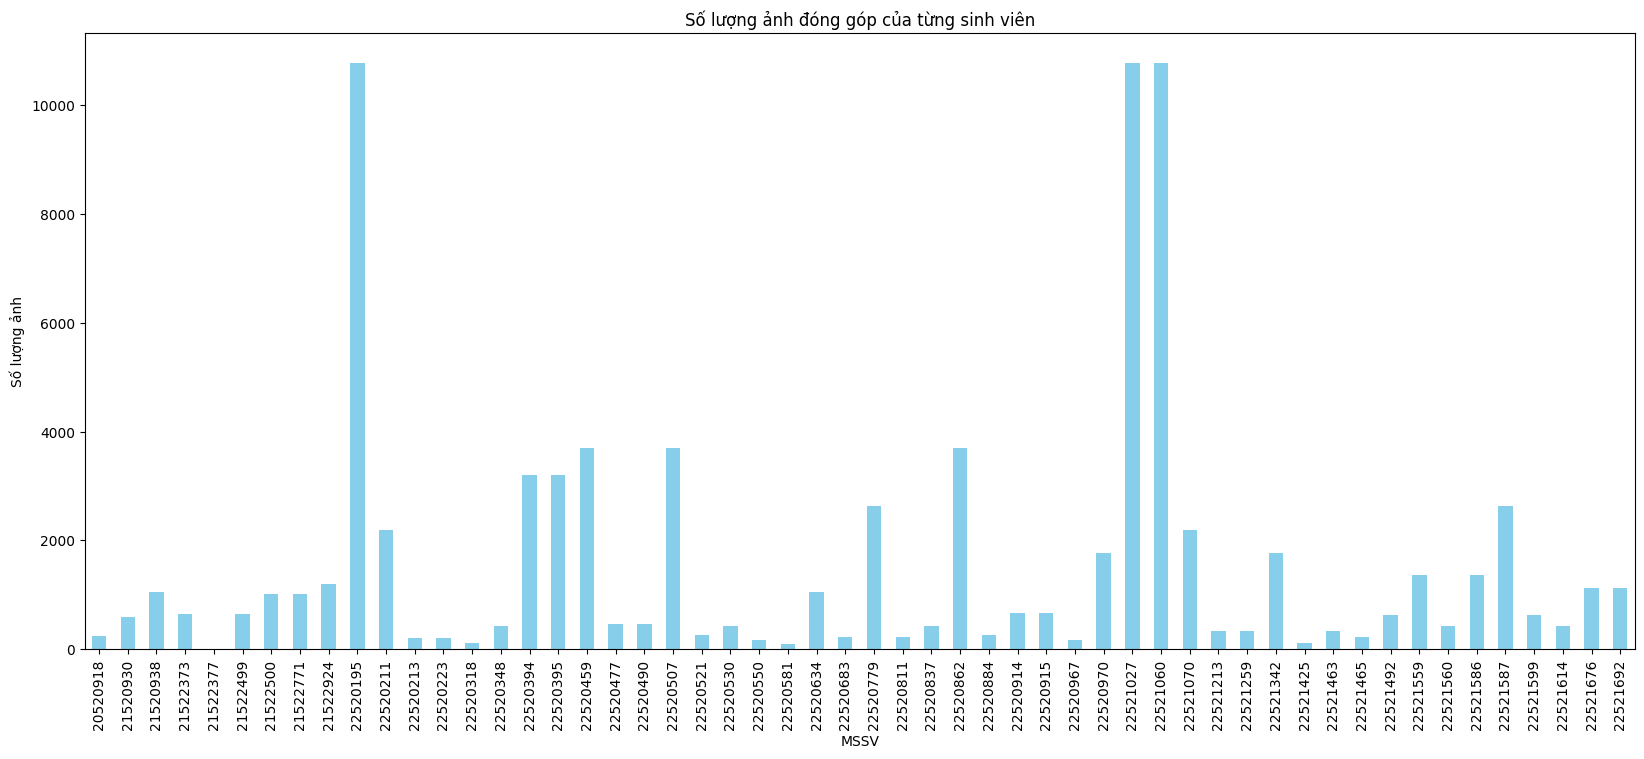

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
file_path = 'CarDataset-1.csv'
car_data = pd.read_csv(file_path)

# Nhóm theo MSSV, tính tổng số ảnh đóng góp của mỗi sinh viên
grouped_data = car_data.groupby('MSSV')['Count'].sum()

# Vẽ biểu đồ cột
plt.figure(figsize=(20, 8))
grouped_data.plot(kind='bar', color='skyblue')

# Thêm tiêu đề và nhãn
plt.title('Số lượng ảnh đóng góp của từng sinh viên')
plt.xlabel('MSSV')
plt.ylabel('Số lượng ảnh')

# Hiển thị biểu đồ
plt.show()


In [25]:
from google.colab import files

# Tải file từ máy tính lên
uploaded = files.upload()


Saving CarDataset-2.csv to CarDataset-2 (1).csv


In [26]:
# Đọc file CSV đã tải lên
import pandas as pd

# Đọc file CSV từ Google Colab
file_path = '/content/CarDataset-2 (1).csv'
car_data = pd.read_csv(file_path)

# Kiểm tra dữ liệu
car_data.head()


,MSSV,Brand,Count
0,22520348,VinFast,49
1,22520348,Toyota,50
2,22520348,Suzuki,50
3,22520348,Others,30
4,22520348,Mitsubishi,50


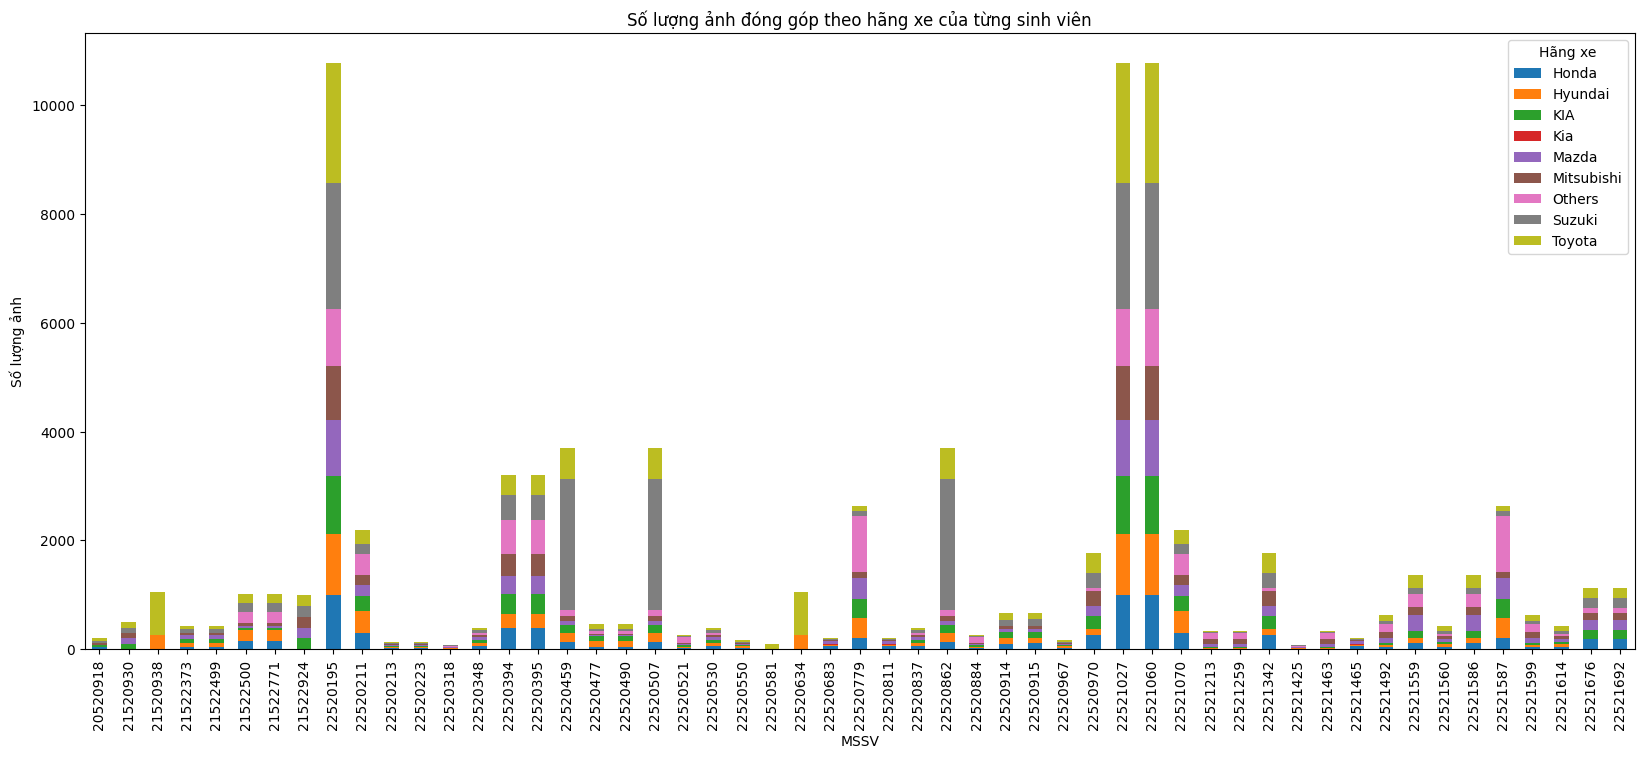

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
file_path = 'CarDataset-2.csv'  # Thay bằng đường dẫn đến file của bạn
car_data = pd.read_csv(file_path)

# Nhóm theo MSSV và Brand, tính tổng số ảnh đóng góp của mỗi sinh viên
grouped_data = car_data.groupby(['MSSV', 'Brand'])['Count'].sum().unstack()

# Vẽ biểu đồ Stacked Bar Chart
grouped_data.plot(kind='bar', stacked=True, figsize=(20, 8))

# Thêm tiêu đề và nhãn
plt.title('Số lượng ảnh đóng góp theo hãng xe của từng sinh viên')
plt.xlabel('MSSV')
plt.ylabel('Số lượng ảnh')
plt.legend(title='Hãng xe')

# Hiển thị biểu đồ
plt.show()


In [43]:
# Nhóm dữ liệu theo MSSV và Brand, tính tổng số ảnh đóng góp của mỗi sinh viên
grouped_data = car_data.groupby(['MSSV', 'Brand'])['Count'].sum().unstack()

# Tìm sinh viên có số lượng ảnh đóng góp cao nhất cho mỗi hãng xe
max_contribution_by_brand = grouped_data.idxmax()
max_contribution_count = grouped_data.max()

# Hiển thị kết quả
for brand in grouped_data.columns:
    print(f"* {brand}: - {max_contribution_by_brand[brand]} - {max_contribution_count[brand]} ảnh.")


* Honda: - 22520195 - 1000.0 ảnh.
* Hyundai: - 22520195 - 1111.0 ảnh.
* KIA: - 22520195 - 1069.0 ảnh.
* Kia: - 22520683 - 12.0 ảnh.
* Mazda: - 22520195 - 1023.0 ảnh.
* Mitsubishi: - 22520195 - 1000.0 ảnh.
* Others: - 22520195 - 1046.0 ảnh.
* Suzuki: - 22520459 - 2400.0 ảnh.
* Toyota: - 22520195 - 2218.0 ảnh.
